In [7]:
from pybatteryid import ModelStructure
from pybatteryid.identification import identify_model
from pybatteryid.utilities import print_model_details, save_model_to_file
from pybatteryid.plotter import plot_time_vs_current

from data import helper

### Example 3 - Model Identification for an LFP Battery

This file contains an example to identify battery models for a 3.5 Ah LFP battery. In this case, a second model input has been introduced representing the maximum hysteresis overpotential. Furthermore, appropriate basis functions corresponding to the second input have also been included. See [2] for more details.

#### References

[1] Sheikh, A. M. A., M. C. F. Donkers, and Henk Jan Bergveld. "A comprehensive approach to sparse identification of linear parameter-varying models for lithium-ion batteries using improved experimental design." Journal of Energy Storage 95 (2024): 112581. https://doi.org/10.1016/j.est.2024.112581

[2] A. M. A. Sheikh, H. J. Bergveld and M. C. F. Donkers, "Investigating Identification Input Designs for Modelling Lithium-ion Batteries with Hysteresis Using LPV Framework," 2024 American Control Conference (ACC), Toronto, ON, Canada, 2024, pp. 1952-1958. https://doi.org/10.23919/ACC60939.2024.10644893.

#### A. Initialize model structure

In [8]:
# The LFP battery being modelled has the capacity around
# 3.5 Ah. The exact value has been calculated by
# coulomb counting during quasi-OCV experiment.
battery_capacity = 13270.180265768407
# The experimental measurements were recorded with 1s
# sampling period.
sampling_period = 1

model_structure = ModelStructure(battery_capacity=battery_capacity, sampling_period=sampling_period)

#### B. Load EMF and Hysteresis data

In [9]:
#
emf_data = helper.load_npy_datasets('data/lfp/quasi_emf.npy')
model_structure.add_emf_function({'soc_values': emf_data['soc_values'],
                                  'voltage_values': emf_data['voltage_values']})
# 
hysteresis_data = helper.load_npy_datasets('data/lfp/hysteresis_data.npy')
model_structure.add_hysteresis_function({'soc_values': hysteresis_data['soc_values'],
                                         'voltage_values': hysteresis_data['voltage_values']})

#### C. Add Basis Functions

In [10]:
model_structure.add_basis_functions(
    ['1/s', 'log[s]', 's', 'exp[0.02*sqrt[|i|]]', 'd[0.01,0.99]'],
    ['d[0.900,1]', 'd[0.995,1.0]', 'd[0.999,1]']
)

#### D. Identify a battery model

We identify a battery model for given model order $n$ and nonlinearity order $l$.

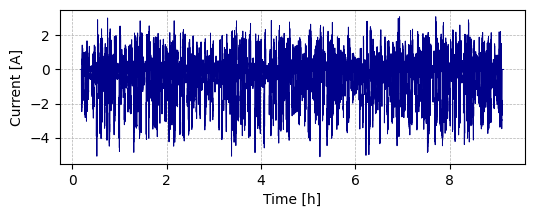

In [11]:
# 
dataset = helper.load_npy_datasets(f'data/lfp/identification_data_first.npy')
#
plot_time_vs_current([(dataset['time'] / 3600, dataset['current'])],
                     units=('h', 'A'), colors=['darkblue'])

In [12]:
identification_dataset = {'initial_soc': dataset['initial_soc'],
                          'time_values': dataset['time'],
                          'current_values': dataset['current'],
                          'voltage_values': dataset['voltage']}
#
model = identify_model(identification_dataset,
                       model_structure,
                       model_order=1, nonlinearity_order=1,
                       optimizers=['lasso.cvxopt', 'ridgecv.sklearn'])

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Inverse condition number of regression matrix: 2.0787259109425247e-05                                           │
│ Dimensions of regression matrix: (32249 rows, 22 columns)                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Performing LASSO using `l1regls.py` from cvxopt.org using lambda_1 = 1. See the following link for details:     │
│ https://cvxopt.org/examples/mlbook/l1regls.html                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

     pcost       dcost       gap    pres   dres
 0: -1.7358e+02 -1.6204e+02  3e+01  1e+01  1e-09
 1: -1.6261e+02 -1.6183e+02  2e+00  8e-01  9e-11
 2: -1.6168e+02 -1.6163e+02  2e-01  7e-02  8e-12
 3: -1.6159e+02 -1.6159e+02  4e-02  1e-02  1e-12
 4: -1.6158e+02 -1.6158e+02  5e-03  1e-03  4e-14
 5: -1.6158e+02 -1.6158e+02  5e-04  6e-05  4e-14
 6: -1.6158e+02 -1.6158e+02  6e-06  7e-07  1e-13
 7: -1.6158e+02 -1.6158e+02  6e-08  7e-09  2e-13
Optimal solution found.


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Performing cross-validated Ridge regression using `sklearn` package.                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Solution found using lambda_2 = alpha = 0.1

#### E. Print Model Details

In [13]:
#
print_model_details(model)

           Model order = 1; Nonlinearity order = 1           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model Term                      ┃ Estimated Parameter     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ v(k-1)                          │ 0.4433079894528973      │
│ v(k-1)×1/s(k-1)                 │ 0.0005494603090165138   │
│ v(k-1)×log[s](k-1)              │ -0.020974207317344874   │
│ v(k-1)×exp[0.02*sqrt[|i|]](k-1) │ 0.43992243657524316     │
│ i(k)                            │ 0.0037630659304706262   │
│ i(k)×1/s(k)                     │ 9.079733902316802e-05   │
│ i(k)×log[s](k)                  │ -0.000639744048198101   │
│ i(k)×exp[0.02*sqrt[|i|]](k)     │ 0.017413518400991097    │
│ i(k)×d[0.01,0.99](k)            │ 0.00031327871424604355  │
│ i(k-1)×1/s(k-1)                 │ -4.8869373289727955e-05 │
│ i(k-1)×log[s](k-1)              │ 0.0011926249836545005   │
│ i(k-1)×exp[0.02*sqrt[|i|]](k-1) │ -0.017512836715632394   │
│ i(k-1)×d[0.01,0.99](k-1)        │ -4.077857350346623e-05  │
│ h(k)                            │ -0.08759269086717919    │
└─────────────────────────────────┴─────────────────────────┘

#### F. Save Model to File

In [14]:
save_model_to_file(model, 'results/lfp', 'model_one')